<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week18_deeplearning_cv/ch18_7_image_search_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch 7. image search part 2.

이번 챕터에서는 이전에 fine-tuning한 신발 이미지 분류 모델을 이용해서 데이터셋으로부터 임베딩 벡터를 뽑아서 벡터 데이터 베이스에 저장해보겠습니다.

## 사전 작업

### 데이터 셋 준비

In [8]:
!unzip "./drive/MyDrive/2023 데이터 분석 및 시각화 취업 과정/shoes.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000924.jpg  
  inflating: /content/shoes/val/boots_ankle/000717.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000717.jpg  
  inflating: /content/shoes/val/boots_ankle/000071.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000071.jpg  
  inflating: /content/shoes/val/boots_ankle/000065.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000065.jpg  
  inflating: /content/shoes/val/boots_ankle/000703.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000703.jpg  
  inflating: /content/shoes/val/boots_ankle/000059.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000059.jpg  
  inflating: /content/shoes/val/boots_ankle/000298.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000298.jpg  
  inflating: /content/shoes/val/boots_ankle/000273.jpg  
  inflating: /content/__MACOSX/shoes/val/boots_ankle/._000273.jpg  
  infl

데이터 셋 클래스에서 모델의 path도 같이 리턴해줄 수 있도록 수정합니다.

In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(f"{img_dir}/label.csv")
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.img_labels.iloc[idx, 0]}"
        img = read_image(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.img_labels.iloc[idx, 1]
        return img, label, img_path

In [9]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transform = weights.transforms()

train_dataset = CustomImageDataset("./shoes/train", transform=transform)
val_dataset = CustomImageDataset("./shoes/val", transform=transform)

In [10]:
import json

with open("./shoes/label_dict.json") as fr:
    label_dict = json.loads(fr.read())

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)

### 모델 준비

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
from torchsummary import summary
from torchvision.models import resnet18

model = resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=12)

In [22]:
weight_path = "/content/drive/MyDrive/dscamp_2023/shoes/weights/resnet18_finetune_1.pth"
weight = torch.load(weight_path, map_location=device)
model.load_state_dict(weight)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 인퍼런스 테스트

로딩된 모델이 인퍼런스를 잘 수행하는지 테스트해보겠습니다.

In [15]:
from PIL import Image
from matplotlib import pyplot as plt


image_dir = "./drive/MyDrive/dscamp_2023/shoes/samples"
file_names = ["example_1.jpg", "example_2.jpg", "example_3.jpg", "example_4.jpg"]
images = [Image.open(f"{image_dir}/{file_name}") for file_name in file_names]

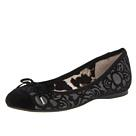

In [16]:
images[0]

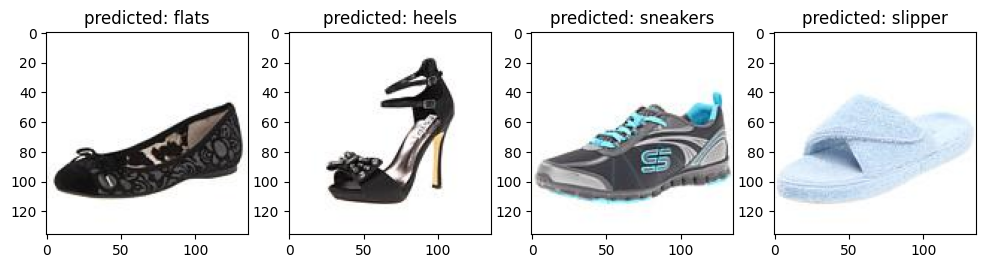

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i, image in enumerate(images):
    image_tensor = transform(image)
    image_tensor = image_tensor.to(device)
    outputs = model(image_tensor.unsqueeze(0))
    probs = torch.nn.functional.softmax(outputs[0], dim=0)
    pred = torch.argmax(probs).item()
    predicted_label = label_dict[str(pred)]
    image_array = image_tensor.cpu().numpy().transpose(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(f"predicted: {predicted_label}")

신발 이미지 분류 테스크에 대해서 fine-tuning한 모델을 성공적으로 불러온 것을 확인할 수 있습니다.

## 임베딩 추출

먼저 train set과 val set의 이미지들로부터 임베딩 벡터를 추출하여 csv 파일에 기록해보겠습니다. 먼저 모델의 특정 레이어의 임베딩 벡터를 가져오려면 register_forward_hook 함수를 이용해 hook을 등록해줍니다. 여기서는 마지막 fully connected layer 직전에 average pooling을 거친 피쳐맵을 가져오겠습니다.

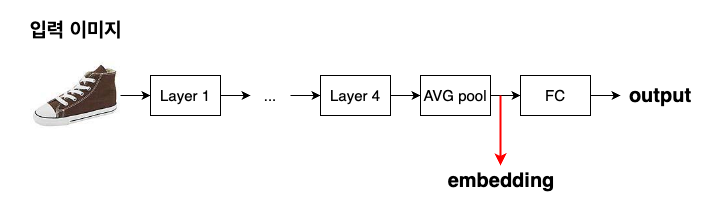

In [27]:
intercepted_embeddings = []

def hook_fn(module, input, output):
    embedding = torch.flatten(output, start_dim=1).cpu().tolist()
    intercepted_embeddings.append(embedding)

model.avgpool.register_forward_hook(hook_fn)

In [30]:
with torch.no_grad():
    image_tensor = transform(images[0]).to(device)
    outputs = model(image_tensor.unsqueeze(0))
    print(intercepted_embeddings[0][0])

[1.231704831123352, 1.5853906869888306, 0.02243969403207302, 0.06016375124454498, 0.0, 2.734790086746216, 1.137228012084961, 2.5665619373321533, 0.18147455155849457, 0.6847383975982666, 0.0005709929973818362, 2.0645644664764404, 1.0418498516082764, 0.9770328402519226, 0.7199274301528931, 0.0, 1.5206516981124878, 4.501062393188477, 0.0, 1.8476275205612183, 1.4081567525863647, 3.520845890045166, 0.003973240498453379, 0.9654121398925781, 0.06513717770576477, 0.3380001485347748, 0.007724450435489416, 0.6528294682502747, 0.4901879131793976, 0.27518346905708313, 0.16878464818000793, 1.1521146297454834, 2.1002659797668457, 0.6330037713050842, 0.2370510697364807, 0.045838408172130585, 0.14529955387115479, 0.5238802433013916, 0.055695731192827225, 0.6497946381568909, 1.3981595039367676, 0.75383061170578, 1.775554895401001, 1.1084595918655396, 0.3975829482078552, 0.2481805831193924, 0.1054435446858406, 1.6228947639465332, 0.1761644035577774, 2.246272087097168, 0.012460502795875072, 0.03663629665

이제 반복문을 돌아주며 각 이미지 별로 임베딩 벡터를 뽑아서 CSV 파일에 기록해줍니다. 이 때 반드시 with torch.no_grad()를 호출해주어야 메모리를 과도하게 사용하지 않습니다.

In [31]:
from tqdm import tqdm
import csv


model = model.to(device)
with open("./drive/MyDrive/dscamp_2023/shoes/embeddings/resnet18_epoch_1.csv", "w") as fw:
    writer = csv.writer(fw)
    writer.writerow(["path", "embedding", "label"])

    for imgs, labels, paths in tqdm(train_dataloader):
        intercepted_embeddings = []
        with torch.no_grad():
            imgs = imgs.to(device)
            _ = model(imgs)
            embeddings = intercepted_embeddings[0]
            for path, embedding, label in zip(paths, embeddings, labels):
                writer.writerow([path, embedding, label.item()])

    for imgs, labels, paths in tqdm(val_dataloader):
        intercepted_embeddings = []
        with torch.no_grad():
            imgs = imgs.to(device)
            _ = model(imgs)
            embeddings = intercepted_embeddings[0]
            for path, embedding, label in zip(paths, embeddings, labels):
                writer.writerow([path, embedding, label.item()])

  0%|          | 0/155 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 39/39 [00:28<00:00,  1.35it/s]


## 결과 확인

임베딩 벡터가 잘 뽑혔는지 한번 확인해보겠습니다.

In [32]:
import pandas as pd

embedding_df = pd.read_csv("./drive/MyDrive/dscamp_2023/shoes/embeddings/resnet18_epoch_1.csv")

In [33]:
embedding_df

,path,embedding,label
0,./shoes/train/sneakers/006295.jpg,"[2.0293993949890137, 1.3646591901779175, 2.102...",11
1,./shoes/train/boots_mid_calf/001344.jpg,"[0.15842297673225403, 0.009625706821680069, 0....",3
2,./shoes/train/sandal/002038.jpg,"[0.36244335770606995, 3.0186431407928467, 0.56...",9
3,./shoes/train/sandal/002888.jpg,"[0.48406320810317993, 1.3516751527786255, 0.06...",9
4,./shoes/train/sneakers/010198.jpg,"[0.1164999008178711, 0.05051806941628456, 1.16...",11
...,...,...,...
49377,./shoes/val/sneakers/002632.jpg,"[2.171173095703125, 2.640693426132202, 3.48221...",11
49378,./shoes/val/sneakers/002633.jpg,"[2.271164655685425, 2.3258280754089355, 2.4479...",11
49379,./shoes/val/sneakers/002634.jpg,"[1.1853768825531006, 1.0254685878753662, 1.810...",11
49380,./shoes/val/sneakers/002635.jpg,"[0.7256677150726318, 0.6890394687652588, 1.412...",11


## 정리

이번 챕터에서는 fine-tuning된 이미지 classification 모델을 가지고 이미지로부터 embedding vector를 뽑아내는 방법에 대해서 익혀보았습니다. 다음 챕터에서는 뽑아낸 벡터를 벡터 데이터 베이스에 저장하고, 이미지 검색을 구현하는 방법에 대해서 배워보겠습니다.